In [125]:
# Dependencies and Setup
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import json
import csv

# Import API key
from config import gkey

In [126]:
#read census csv file
census_df = pd.read_csv("Resources/censusdata.csv")
census_df.head()

,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,601,17599.0,38.9,11757.0,7041.0,11282.0,64.105915
1,602,39209.0,40.9,16190.0,8978.0,20428.0,52.100283
2,603,50135.0,40.4,16645.0,10897.0,25176.0,50.216416
3,606,6304.0,42.8,13387.0,5960.0,4092.0,64.911168
4,610,27590.0,41.4,18741.0,9266.0,12553.0,45.498369


In [127]:
# Testing how many records came thru
len(census_df.index)

33120

In [128]:
#read zip code csv file
zip_df = pd.read_csv("Resources/zip_code_database.csv")
# only utilize zip city state country lat lng
zip_df = zip_df.loc[:, ['zip','primary_city', 'state', 'country', 'latitude', 'longitude']]
zip_df = zip_df.rename(columns={"zip": "Zipcode"})
zip_df.head()

,Zipcode,primary_city,state,country,latitude,longitude
0,501,Holtsville,NY,US,40.81,-73.04
1,544,Holtsville,NY,US,40.81,-73.04
2,601,Adjuntas,PR,US,18.16,-66.72
3,602,Aguada,PR,US,18.38,-67.18
4,603,Aguadilla,PR,US,18.43,-67.15


In [129]:
# Merge Census and Zipcode dataframes using an inner join
merge_table = pd.merge(census_df, zip_df, on="Zipcode")
merge_table['location'] = list(zip(merge_table["latitude"] , merge_table["longitude"]))
# merge_table = merge_table['latitude'].astype(float)
# merge_table = merge_table['longitude'].astype(float)
merge_table.head()

,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,primary_city,state,country,latitude,longitude,location
0,601,17599.0,38.9,11757.0,7041.0,11282.0,64.105915,Adjuntas,PR,US,18.16,-66.72,"(18.16, -66.72)"
1,602,39209.0,40.9,16190.0,8978.0,20428.0,52.100283,Aguada,PR,US,18.38,-67.18,"(18.38, -67.18)"
2,603,50135.0,40.4,16645.0,10897.0,25176.0,50.216416,Aguadilla,PR,US,18.43,-67.15,"(18.43, -67.15)"
3,606,6304.0,42.8,13387.0,5960.0,4092.0,64.911168,Maricao,PR,US,18.18,-66.98,"(18.18, -66.98)"
4,610,27590.0,41.4,18741.0,9266.0,12553.0,45.498369,Anasco,PR,US,18.28,-67.14,"(18.28, -67.14)"


In [130]:
# Testing how many records came thru
len(merge_table.index)

33120

In [131]:
# pull in cell tower csv.
cell_df = pd.read_csv("OCID-diff-cell-export-2019-09-23-T000000.csv")

# limit mcc code to only view US cell towers. mcc 310 thru 316
cell_df = cell_df[(cell_df['mcc'] >= 310) & (cell_df['mcc'] <= 316)]

cell_df.head()

,radio,mcc,net,area,cell,unit,lon,lat,range,samples,changeable,created,updated,averageSignal
5130,LTE,310,410,26392,62427664,0,-89.945058,38.570057,6091,18,1,1372431182,1569163819,0
5358,UMTS,310,410,6992,131958701,0,-71.243112,42.705354,8239,8,1,1238903547,1569183960,0
5402,UMTS,310,410,30952,86998975,0,-91.458878,44.819621,3735,12,1,1317080006,1569193913,0
5403,UMTS,310,410,27398,231629347,0,-80.652073,28.030082,6537,78,1,1318201398,1569169421,0
5404,UMTS,310,410,27398,231629346,0,-80.623494,28.043499,3775,31,1,1318201500,1569170874,0


In [132]:
# round lat and longitude
cell_df = cell_df.round({'lon': 2, 'lat': 2})

#create location column to potentially utilize to generate city information from gmaps api
cell_df['location'] = list(zip(cell_df["lat"] , cell_df["lon"]))

cell_df.head()

,radio,mcc,net,area,cell,unit,lon,lat,range,samples,changeable,created,updated,averageSignal,location
5130,LTE,310,410,26392,62427664,0,-89.95,38.57,6091,18,1,1372431182,1569163819,0,"(38.57, -89.95)"
5358,UMTS,310,410,6992,131958701,0,-71.24,42.71,8239,8,1,1238903547,1569183960,0,"(42.71, -71.24)"
5402,UMTS,310,410,30952,86998975,0,-91.46,44.82,3735,12,1,1317080006,1569193913,0,"(44.82, -91.46)"
5403,UMTS,310,410,27398,231629347,0,-80.65,28.03,6537,78,1,1318201398,1569169421,0,"(28.03, -80.65)"
5404,UMTS,310,410,27398,231629346,0,-80.62,28.04,3775,31,1,1318201500,1569170874,0,"(28.04, -80.62)"


In [133]:
# Testing how many records came thru
len(cell_df.index)

7980

In [134]:
# Limit the radio signal to 4g LTE
df = cell_df[(cell_df['radio'] == "LTE")].reset_index()

df.head()

,index,radio,mcc,net,area,cell,unit,lon,lat,range,samples,changeable,created,updated,averageSignal,location
0,5130,LTE,310,410,26392,62427664,0,-89.95,38.57,6091,18,1,1372431182,1569163819,0,"(38.57, -89.95)"
1,5409,LTE,310,410,12994,218632723,0,-78.81,35.76,1454,4,1,1326722189,1569121159,0,"(35.76, -78.81)"
2,5416,LTE,310,410,55508,56082592,0,-117.09,33.50,1405,2,1,1333304933,1569188822,0,"(33.5, -117.09)"
3,5443,LTE,310,410,56868,4994334,0,-121.48,38.44,1463,2,1,1354314460,1569162782,0,"(38.44, -121.48)"
4,5450,LTE,310,410,36111,171900943,0,-121.44,38.49,6926,29,1,1361407340,1569117472,0,"(38.49, -121.44)"


In [135]:
# Merge census data with cell tower data by zipcode
df = df.rename(columns={"area": "Zipcode"})
merge_tower = pd.merge(df, merge_table, on=["Zipcode"])
merge_tower.head()

,index,radio,mcc,net,Zipcode,cell,unit,lon,lat,range,...,Household Income,Per Capita Income,Poverty Count,Poverty Rate,primary_city,state,country,latitude,longitude,location_y
0,5450,LTE,310,410,36111,171900943,0,-121.44,38.49,6926,...,46502.0,29153.0,2276.0,18.050599,Montgomery,AL,US,32.34,-86.27,"(32.34, -86.27)"
1,7643,LTE,310,410,36111,171888394,0,-121.44,38.51,7286,...,46502.0,29153.0,2276.0,18.050599,Montgomery,AL,US,32.34,-86.27,"(32.34, -86.27)"
2,8845,LTE,310,410,36111,171887631,0,-121.34,38.36,19422,...,46502.0,29153.0,2276.0,18.050599,Montgomery,AL,US,32.34,-86.27,"(32.34, -86.27)"
3,8847,LTE,310,410,36111,171913481,0,-121.47,38.55,8301,...,46502.0,29153.0,2276.0,18.050599,Montgomery,AL,US,32.34,-86.27,"(32.34, -86.27)"
4,8849,LTE,310,410,36111,171891464,0,-121.48,38.54,6869,...,46502.0,29153.0,2276.0,18.050599,Montgomery,AL,US,32.34,-86.27,"(32.34, -86.27)"


In [136]:
# Testing how many records came thru
len(merge_tower.index)

2607

In [137]:
merge_tower.drop(merge_tower.loc[merge_tower['Household Income']<0].index, inplace=True)
merge_tower.head()


,index,radio,mcc,net,Zipcode,cell,unit,lon,lat,range,...,Household Income,Per Capita Income,Poverty Count,Poverty Rate,primary_city,state,country,latitude,longitude,location_y
0,5450,LTE,310,410,36111,171900943,0,-121.44,38.49,6926,...,46502.0,29153.0,2276.0,18.050599,Montgomery,AL,US,32.34,-86.27,"(32.34, -86.27)"
1,7643,LTE,310,410,36111,171888394,0,-121.44,38.51,7286,...,46502.0,29153.0,2276.0,18.050599,Montgomery,AL,US,32.34,-86.27,"(32.34, -86.27)"
2,8845,LTE,310,410,36111,171887631,0,-121.34,38.36,19422,...,46502.0,29153.0,2276.0,18.050599,Montgomery,AL,US,32.34,-86.27,"(32.34, -86.27)"
3,8847,LTE,310,410,36111,171913481,0,-121.47,38.55,8301,...,46502.0,29153.0,2276.0,18.050599,Montgomery,AL,US,32.34,-86.27,"(32.34, -86.27)"
4,8849,LTE,310,410,36111,171891464,0,-121.48,38.54,6869,...,46502.0,29153.0,2276.0,18.050599,Montgomery,AL,US,32.34,-86.27,"(32.34, -86.27)"


In [138]:
#count number of cell towers by city
df_counts = merge_tower["primary_city"].value_counts()
df_counts.head()

South Boston    119
Westfield       118
Stillwater      115
Newton Falls    108
New Lisbon       91
Name: primary_city, dtype: int64

In [139]:
census_df= merge_tower.loc[:, ['primary_city', 'state', 'Household Income']]
census_df = census_df.groupby(['primary_city'])
census_df.mean().head()

,Household Income
primary_city,
Abingdon,85961.0
Absecon,63194.0
Adrian,46719.0
Ahoskie,36240.0
Albany,68053.0


In [140]:
census_df["Household Income"].mean()
census_df.head()

,primary_city,state,Household Income
0,Montgomery,AL,46502.0
1,Montgomery,AL,46502.0
2,Montgomery,AL,46502.0
3,Montgomery,AL,46502.0
4,Montgomery,AL,46502.0
20,Lebanon,NJ,137063.0
21,Lebanon,NJ,137063.0
22,Lebanon,NJ,137063.0
23,Lebanon,NJ,137063.0
24,Lebanon,NJ,137063.0


In [141]:
census_mean = census_df["Household Income"].mean()
census_mean.head()

primary_city
Abingdon    85961.0
Absecon     63194.0
Adrian      46719.0
Ahoskie     36240.0
Albany      68053.0
Name: Household Income, dtype: float64

In [145]:
# Creating a new DataFrame using both Income and Count
summary_table = pd.DataFrame({"Household Income": census_mean,
                                    "Count of Towers": df_counts})
summary_table["Household Income"] = summary_table["Household Income"] / 1000
summary_table

,Household Income,Count of Towers
Abingdon,85.961000,2
Absecon,63.194000,61
Adrian,46.719000,34
Ahoskie,36.240000,4
Albany,68.053000,2
Barwick,37.500000,4
Biscoe,38.424000,1
Black River,64.877000,18
Bowersville,35.000000,3
Boyce,88.603000,3


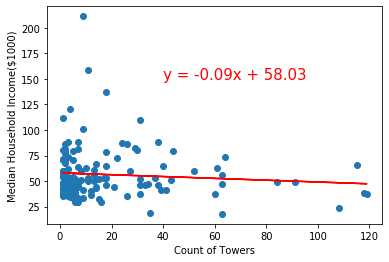

In [148]:
# Add the linear regression equation and line to plot
x_values = summary_table['Count of Towers']
y_values = summary_table['Household Income']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(40,150),fontsize=15,color="red")
plt.xlabel('Count of Towers')
plt.ylabel('Median Household Income($1000)')
plt.savefig("Images/MedianIncome.png")
plt.show()

In [71]:
Pop_census_df= merge_tower.loc[:, ['primary_city', 'state', 'Population']]
Pop_census_df = Pop_census_df.groupby(['primary_city'])
Pop_census_df.mean().head()

,Population
primary_city,
Abingdon,29870.0
Absecon,28275.0
Adrian,948.0
Ahoskie,12015.0
Albany,20520.0


In [75]:
Pop_census_df["Population"].mean()
Pop_census_df.head()

,primary_city,state,Population
0,Montgomery,AL,12609.0
1,Montgomery,AL,12609.0
2,Montgomery,AL,12609.0
3,Montgomery,AL,12609.0
4,Montgomery,AL,12609.0
20,Lebanon,NJ,8322.0
21,Lebanon,NJ,8322.0
22,Lebanon,NJ,8322.0
23,Lebanon,NJ,8322.0
24,Lebanon,NJ,8322.0


In [78]:
Pop_total = Pop_census_df["Population"].mean()
Pop_total.head()

primary_city
Abingdon    29870.0
Absecon     28275.0
Adrian        948.0
Ahoskie     12015.0
Albany      20520.0
Name: Population, dtype: float64

In [79]:
# Creating a new DataFrame using both Population and Count
population_table = pd.DataFrame({"Population": Pop_total,
                                    "Count of Towers": df_counts})
population_table

,Population,Count of Towers
Abingdon,29870.0,2
Absecon,28275.0,61
Adrian,948.0,34
Ahoskie,12015.0,4
Albany,20520.0,2
Barwick,350.0,4
Biscoe,4415.0,1
Black River,2382.0,18
Bowersville,321.0,3
Boyce,2531.0,3


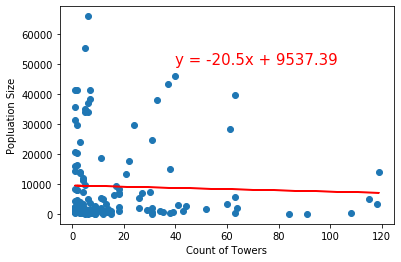

In [96]:
# Add the linear regression equation and line to plot
x_values = population_table['Count of Towers']
y_values = population_table['Population']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(40,50000),fontsize=15,color="red")
plt.xlabel('Count of Towers')
plt.ylabel('Popluation Size')
plt.savefig("Images/PopulationSize.png")
plt.show()